# Setup

In [1]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from sparknlp.base import LightPipeline
import pyspark.sql.functions as F
from pyspark.sql import Row

import os
import json
import numpy as ny
import pandas as pd
import dataprofiler as dp
import matplotlib.pyplot as plt
path="data/data_set_fusion.csv"

In [2]:
spark = sparknlp.start()
print("Spark NLP version: {}".format(sparknlp.version()))
print("Apache Spark version: {}".format(spark.version))

Spark NLP version: 3.3.2
Apache Spark version: 3.1.2


### réussi de télécharger modèle en local sans problème

In [3]:
pipeline = PretrainedPipeline('entity_recognizer_md', lang = 'fr')
#pipeline = PretrainedPipeline.from_disk('entity_recognizer_md_fr')

entity_recognizer_md download started this may take some time.
Approx size to download 443.9 MB
[OK!]


# Spark NLP

In [4]:
# transfer list of Row into list of True (detected >= 2/3) and False (non detected)
def getResultSNLP(list_ner, entity):
    result_snlp = []
    for ner in list_ner:
        cpt = 0
        for i in range(len(ner.ner)):
            if entity in ner.ner[i]:
                cpt += 1
        result_snlp.append(cpt/len(ner.ner) >= 2/3)
    return result_snlp

In [5]:
def runSparkNLP(data, entity):
    annotations = pipeline.transform(data)
    # annotations.show(n=30, truncate=False)
    list_ner = annotations.selectExpr("ner.result AS ner").collect() # list of Row (each Row is list of entity detected)
    return getResultSNLP(list_ner, entity)

# Data Profiler

In [6]:
def runDataProfiler(data, entity):
    labeler = dp.DataLabeler(labeler_type='structured')
    predictions = labeler.predict(data)
    result_dp = [p == entity for p in predictions['pred']]
    return result_dp

# Comparaison 
### cas une colonnes contient un type d'information unique - PER, LOC, etc <=> on n'a que Positive, aucun Negative

In [7]:
def comparaison(result_snlp, result_dp):
    result_list = {'both': 0, 'snlp': 0, 'dp': 0, 'none': 0}
    for i in range(len(result_snlp)):
        if result_snlp[i]:
            if result_dp[i]: result_list['both'] += 1
            else: result_list['snlp'] += 1
        else:
            if result_dp[i]: result_list['dp'] += 1
            else: result_list['none'] += 1

    print(result_list)
    plt.pie(list(result_list.values()), labels = list(result_list.keys()))
    plt.legend(title = "Detection Rate")
    plt.show()

    recall_snlp = result_snlp.count(True) / len(result_snlp)
    recall_dp = result_dp.count(True) / len(result_dp)
    print("Recall Spark NLP:", recall_snlp)
    print("Recall Data Profiler:", recall_dp)
    recall = [recall_snlp, recall_dp]
    plt.bar(["Spark NLP", "Data Profiler"], recall)
    plt.ylabel('Recall')
    plt.show()

In [8]:
def getResult(column, entity_snlp, entity_dp):
    df_spark = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path)
    data = df_spark.select(column).toDF("text")
    result_snlp = runSparkNLP(data, entity_snlp)

    data = dp.Data(path, options=dict(selected_columns=[column]))
    result_dp =  runDataProfiler(data, entity_dp)
    return result_snlp, result_dp

## nom

In [9]:
result_snlp, result_dp = getResult('nom', 'PER', 'PERSON')

{'both': 8625, 'snlp': 29227, 'dp': 344, 'none': 1800}


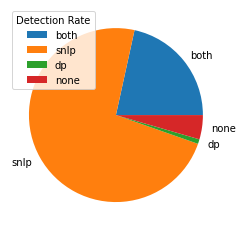

Recall Spark NLP: 0.9463946394639464
Recall Data Profiler: 0.22424742474247425


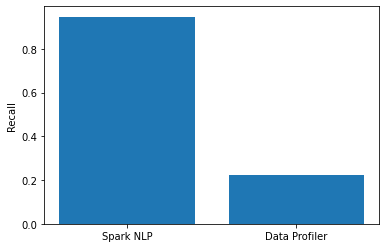

In [10]:
comparaison(result_snlp, result_dp)

## adresse

In [11]:
df_spark = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path)
annotations = pipeline.transform(df_spark.select('adresse').toDF("text"))
annotations = annotations.selectExpr("token.result AS token", "ner.result AS ner")
annotations.show(truncate=False)

+---------------------------------------------------------------------------+----------------------------------------------------------------+
|token                                                                      |ner                                                             |
+---------------------------------------------------------------------------+----------------------------------------------------------------+
|[6, Place, du, Pese, Lait, 1640, L'Abergement-de-Varey]                    |[O, I-MISC, I-MISC, I-MISC, I-MISC, I-MISC, I-MISC]             |
|[1, Les, Granges, 1640, L'Abergement-de-Varey]                             |[O, O, I-MISC, I-MISC, I-MISC]                                  |
|[2, Les, Granges, 1640, L'Abergement-de-Varey]                             |[O, O, I-MISC, I-MISC, I-MISC]                                  |
|[10, Les, Granges, 1640, L'Abergement-de-Varey]                            |[O, O, I-MISC, I-MISC, I-MISC]                                  |

In [12]:
result_snlp, result_dp = getResult('adresse', 'LOC', 'ADDRESSE')

{'both': 0, 'snlp': 17075, 'dp': 0, 'none': 22921}


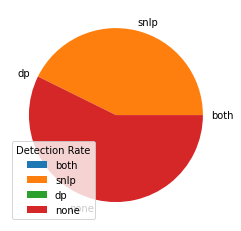

Recall Spark NLP: 0.42691769176917693
Recall Data Profiler: 0.0


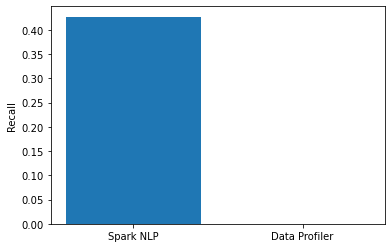

In [13]:
comparaison(result_snlp, result_dp)

# Cas mélange 2 colonnes



In [14]:
import random

n = 20000 # prendre n lignes chacun

df = pd.read_csv(path)
fusion_data = pd.DataFrame()
fusion_data['data'] = pd.concat([df['nom'][:n], df['adresse'][:n]])
fusion_data['class'] = ['PER']*n + ['LOC']*n
fusion_data = fusion_data.sample(frac=1)

from pyspark.sql.types import StringType
fusion_data_snlp = spark.createDataFrame(fusion_data['data'].tolist(), StringType()).toDF('text')
fusion_data

,data,class
2392,8 Rue Aristide Briand 1500 Ambérieu-en-Bugey,LOC
2927,Mariem Sarmiento,PER
4428,Reverien Mizuno,PER
4658,Merveille Moons,PER
9707,2612 Chemin de Tanvol 1440 Viriat,LOC
...,...,...
6393,Ding Serdarov,PER
19830,170 Lotissement Genévriers les Coudriers 1210 ...,LOC
19751,Maddie Waage,PER
3860,Evens Dikgang,PER


In [15]:
annotations = pipeline.transform(fusion_data_snlp)
annotations = annotations.selectExpr("token.result AS token", "ner.result AS ner")
annotations.show(truncate=False)

+----------------------------------------------------------+------------------------------------------------+
|token                                                     |ner                                             |
+----------------------------------------------------------+------------------------------------------------+
|[8, Rue, Aristide, Briand, 1500, Ambérieu-en-Bugey]       |[O, I-LOC, I-PER, I-PER, I-PER, I-PER]          |
|[Mariem, Sarmiento]                                       |[I-PER, I-PER]                                  |
|[Reverien, Mizuno]                                        |[I-PER, I-PER]                                  |
|[Merveille, Moons]                                        |[I-MISC, I-MISC]                                |
|[2612, Chemin, de, Tanvol, 1440, Viriat]                  |[O, I-MISC, I-MISC, I-MISC, I-MISC, I-MISC]     |
|[26, Rue, Marcel, et, Ida, Demia, 1500, Ambérieu-en-Bugey]|[O, I-PER, I-PER, O, I-PER, I-PER, I-PER, I-PER]|
|[3, Rue, 

In [16]:
def countResult(pred, act):
    l = len(act)
    tp = [act[i] == pred[i] == True for i in range(l)]
    fp = [act[i] == False and pred[i] == True for i in range(l)]
    tn = [act[i] == pred[i] == False for i in range(l)]
    fn = [act[i] == True and pred[i] == False for i in range(l)]
    result_count = [tp.count(True), fp.count(True), tn.count(True), fn.count(True)]
    print("TP: ", result_count[0], " // FP: ", result_count[1], " // TN: ", result_count[2], " // FN: ", result_count[3])
    return result_count

In [17]:
def comparaison2(result_snlp, result_dp, actual_class):
    print("Count result of SNLP:")
    count_snlp = countResult(result_snlp, actual_class)
    print("Count result of DP:")
    count_dp = countResult(result_dp, actual_class)
    
    #Recall = TP/(TP+ FN)
    recall_snlp = count_snlp[0] / (count_snlp[0] + count_snlp[3]) if (count_snlp[0] + count_snlp[3]) != 0 else 0
    recall_dp = count_dp[0] / (count_dp[0] + count_dp[3]) if (count_dp[0] + count_dp[3]) != 0 else 0
    print("Recall Spark NLP:", recall_snlp)
    print("Recall Data Profiler:", recall_dp)
    recall = [recall_snlp, recall_dp]
    plt.bar(["Spark NLP", "Data Profiler"], recall)
    plt.ylabel('Recall')
    plt.show()
    
    #Precision = TP/(TP + FP)
    prec_snlp = count_snlp[0] / (count_snlp[0] + count_snlp[1]) if (count_snlp[0] + count_snlp[1]) != 0 else 0
    prec_dp = count_dp[0] / (count_dp[0] + count_dp[1]) if (count_dp[0] + count_dp[1]) != 0 else 0
    print("Precision Spark NLP:", prec_snlp)
    print("Precision Data Profiler:", prec_dp)
    precision = [prec_snlp, prec_dp]
    plt.bar(["Spark NLP", "Data Profiler"], precision)
    plt.ylabel('Precision')
    plt.show()

## nom

Count result of SNLP:
TP:  19082  // FP:  1668  // TN:  18332  // FN:  918
Count result of DP:
TP:  4412  // FP:  296  // TN:  19704  // FN:  15588
Recall Spark NLP: 0.9541
Recall Data Profiler: 0.2206


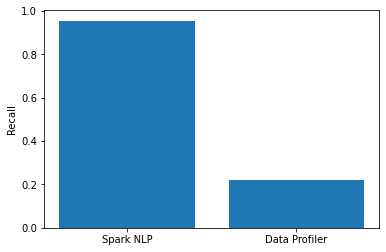

Precision Spark NLP: 0.9196144578313253
Precision Data Profiler: 0.9371282922684792


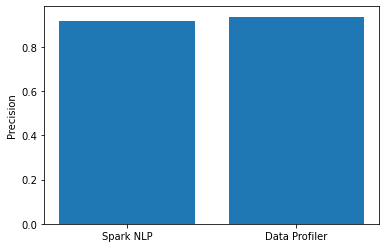

In [18]:
result_snlp = runSparkNLP(fusion_data_snlp, 'PER')
result_dp =  runDataProfiler(fusion_data['data'], 'PERSON')
actual_class = [d == 'PER' for d in fusion_data['class']]
comparaison2(result_snlp, result_dp, actual_class)

## adresse

Count result of SNLP:
TP:  9441  // FP:  235  // TN:  19765  // FN:  10559
Count result of DP:
TP:  0  // FP:  0  // TN:  20000  // FN:  20000
Recall Spark NLP: 0.47205
Recall Data Profiler: 0.0


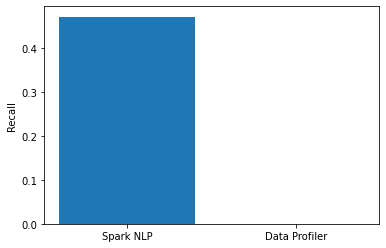

Precision Spark NLP: 0.975713104588673
Precision Data Profiler: 0


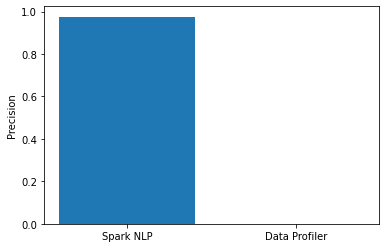

In [19]:
result_snlp = runSparkNLP(fusion_data_snlp, 'LOC')
result_dp =  runDataProfiler(fusion_data['data'], 'ADDRESSE')
actual_class = [d == 'LOC' for d in fusion_data['class']]
comparaison2(result_snlp, result_dp, actual_class)

# Spark NLP + Data Profiler

In [20]:
def get_structured_results(results):
    columns = []
    predictions = []
    for col_report in results['data_stats']:
        columns.append(col_report['column_name'])
        predictions.append(col_report['data_label'])
        
    df_results = pd.DataFrame({'Column' : columns, 'Pred DP' : predictions})
    return df_results

In [21]:
data = dp.Data(path)
df_data = data.data
df_data.head()

,type_de_carte,numero_de_carte,iban,nom,tel,email,adresse,date
0,Visa,4998333238637277,AL55428419020208960868,Ivan Mohamed,+33692972790,iDYjKeJPwUj.OfWk1p@yahoo.com,6 Place du Pese Lait 1640 L'Abergement-de-Varey,2018-10-05 03:03:48
1,Visa,4532989368815505,XU224328033937652854,Ali Hernandez,+33907982343,1VHbkTUz+CUTb+un@hotmail.com,1 Les Granges 1640 L'Abergement-de-Varey,2020-04-02 04:17:10
2,Visa,4916767269587027,DK6360606409884633087,Jack Gashi,+33348464665,NfdO++RnYVHTNKWI3@me.io,2 Les Granges 1640 L'Abergement-de-Varey,2020-09-10 01:39:24
3,Visa,4485065267473279,BR24328056271230216081,Eric Tamm,+33451017552,gz6YlBr+vJrP@yahoo.com,10 Les Granges 1640 L'Abergement-de-Varey,2018-08-22 11:57:48
4,Visa,4929375970407322,BC7494751232040117367,Mohammed Kumar,0992976429,Wy_OnHf5AZ35ENUlERFH@outlook.fr,1082 Chemin de la Ferm de la Montagne 1640 L'A...,2019-08-16 17:55:11


In [22]:
profiler = dp.Profiler(data)
results = profiler.report(report_options={'output_format':'compact'})

INFO:DataProfiler.profilers.profile_builder: Finding the Null values in the columns...  (with 3 processes)


/Users/todungnguyen/opt/anaconda3/lib/python3.8/site-packages/dataprofiler/profilers/profile_builder.py:1960: UserWarning: The data will be profiled with a sample size of 7999. All statistics will be based on this subsample and not the whole dataset.
  warnings.warn("The data will be profiled with a sample size of {}. "
100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


INFO:DataProfiler.profilers.profile_builder: Calculating the statistics...  (with 4 processes)


 25%|██▌       | 2/8 [00:02<00:06,  1.05s/it]

 50%|█████     | 4/8 [00:02<00:02,  1.99it/s]

100%|██████████| 8/8 [00:03<00:00,  2.01it/s]


In [23]:
df_result = get_structured_results(results)
print(df_result)

            Column           Pred DP
0    type_de_carte           UNKNOWN
1  numero_de_carte       CREDIT_CARD
2             iban               BAN
3              nom           UNKNOWN
4              tel  BAN|PHONE_NUMBER
5            email     EMAIL_ADDRESS
6          adresse           UNKNOWN
7             date          DATETIME


### ne fait que Spark NLP sur les cols UNKNOWN ou sur tout?

In [24]:
unknown_cols = []
for index, row in df_result.iterrows():
    if row['Pred DP'] == 'UNKNOWN':
        unknown_cols.append(row['Column'])
print(unknown_cols)

['type_de_carte', 'nom', 'adresse']


In [25]:
for i in df_result['Pred DP']:
    print(i)

UNKNOWN
CREDIT_CARD
BAN
UNKNOWN
BAN|PHONE_NUMBER
EMAIL_ADDRESS
UNKNOWN
DATETIME


In [26]:
def getResult2(column):
    df_spark = spark.read.format("csv").option("header","true").option("inferSchema","true").load(path)
    data = df_spark.select(column).toDF("text")
    annotations = pipeline.transform(data)
    list_ner = annotations.selectExpr("ner.result AS ner").collect()
    return getResultSNLP2(list_ner)

In [27]:
def getResultSNLP2(list_ner):
    result_snlp = []
    for ner in list_ner:
        count_entity = {'PER': 0, 'LOC': 0, 'MISC': 0, 'ORG': 0}
        for i in range(len(ner.ner)):
            for key in count_entity.keys():
                if key in ner.ner[i]:
                    count_entity[key] += 1
        max_key = max(count_entity, key = count_entity.get)
        if count_entity[max_key]/len(ner.ner) < 2/3:
            max_key = "UNKNOWN"
        result_snlp.append(max_key)
    return max(result_snlp, key = result_snlp.count)

In [28]:
#df_result['Pred SNLP'] = ['UNKNOWN']*df_result.shape[0]
#df_result

In [29]:
for col in unknown_cols:
    df_result.at[df_result['Column'] == col, 'Pred DP'] = getResult2(col)
print(df_result)

            Column           Pred DP
0    type_de_carte               ORG
1  numero_de_carte       CREDIT_CARD
2             iban               BAN
3              nom               PER
4              tel  BAN|PHONE_NUMBER
5            email     EMAIL_ADDRESS
6          adresse               LOC
7             date          DATETIME


In [30]:
try:
    sparknlp.stop()
except:
    pass